Globally averaged temperature:

$$
\frac{dT}{dt} = R_i(T) -  R_0(T, C)
$$


$$
R_i(T) = \frac{Q_0}{c} (1 - p \alpha_\text{land} - p \alpha_\text{oc}(T)) 
$$

$$
R_o(T) = \frac{1}{c} (\kappa (T - T_\kappa) - a \ln (\frac{C}{C_0}) )
$$


Accumulated anthropogenic carbon, $S_a$
$$
\frac{d S_a}{dt} = C_a
$$

Atmospheric carbon concentration:

$$
\frac{dC}{dt} = v + C_a - W_a A_v C g^{vege}(T) + \frac{c_0}{\tau_c} \kappa_P (1 - f(T)) + \frac{c_0}{\tau_c} \kappa_B(S_a) (1 - f(T)) - \frac{\lambda}{\tau_c} C(1 - f(T))
$$

Temperature anomaly:
$$
\tilde{T} = T - T_{preindustrial}
$$



$$
\begin{align}
\delta \phi(\tilde{T}, C, S_a) =& \max_{C_a} \eta \log C_a  \\
& + \frac{d \phi (\tilde{T}, C, S_a)}{d\tilde{T}} \left( R_i(T) - R_0(T, C) \right)\\
& + \frac{d\phi(\tilde{T}, C, S_a)}{d C} \left( v + C_a - W_a A_v C g^{vege}(T) + \frac{c_0}{\tau_c} \kappa_P (1 - f(T)) + \frac{c_0}{\tau_c} \kappa_B(S_a) (1 - f(T)) - \frac{\lambda}{\tau_c} C(1 - f(T))\right)\\
& + \frac{d \phi (\tilde{T}, C, S_a)}{d S_a} C_a \\
& + \frac{(\eta - 1)}{\delta} (\gamma_1 + \gamma_2 \tilde{T}) (R_i(T) - R_0(T, C))
\end{align}
$$

$$
C_a^{*} = - \frac{ \eta}{\frac{d \phi (\tilde{T}, C, S_a)}{d C} + \frac{d \phi (\tilde{T}, C, S_a)}{d S_a} }
$$

In [63]:
from supportfunctions import finiteDiff
import SolveLinSys
from scipy.interpolate import RegularGridInterpolator
from scipy import fft, arange, signal
from scipy import interpolate
from scipy.optimize import curve_fit
import scipy.optimize as optim
import scipy.io as sio
import matplotlib.mlab
from matplotlib.colors import SymLogNorm
from matplotlib import rcParams
from matplotlib import pyplot as plt
from scipy.fft import fft, fftfreq
from scipy.integrate import solve_ivp
import pickle
import pandas as pd
import numpy as np
import sys
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual

sys.path.append("../src/")
rcParams["figure.figsize"] = (8, 5)
rcParams["savefig.bbox"] = 'tight'


def PDESolver(stateSpace, A, B1, B2, B3, C1, C2, C3, D, v0,
              ε=1, tol=-10):

    A = A.reshape(-1, 1, order='F')
    B = np.hstack([B1.reshape(-1, 1, order='F'), B2.reshape(-1,
                  1, order='F'), B3.reshape(-1, 1, order='F')])
    C = np.hstack([C1.reshape(-1, 1, order='F'), C2.reshape(-1,
                  1, order='F'), C3.reshape(-1, 1, order='F')])
    D = D.reshape(-1, 1, order='F')
    v0 = v0.reshape(-1, 1, order='F')
    out = SolveLinSys.solveFT(stateSpace, A, B, C, D, v0, ε, tol)

    return out


In [26]:
# Pre-industrial: 282.87K

sa = 1
Ts = 282.9
Cs = 275.5

Q0 = 342.5
p = 0.3
# outgoing radiation linearized
kappa = 1.74
Tkappa = 154
## CO2 radiative forcing
# Greenhouse effect parameter
B = 5.35

alphaland = 0.28
bP = 0.05
bB = 0.08
cod = 3.035
cearth = 10.  # 35 #0.107
tauc = 20.

cearth = 35.
tauc = 6603.

coc0 = 350
## Ocean albedo parameters
Talphaocean_low = 219
Talphaocean_high = 299
alphaocean_max = 0.84
alphaocean_min = 0.255

Cbio_low = 50
Cbio_high = 700

T0 = 298
C0 = 280

## CO2 uptake by vegetation
wa = 0.015
vegcover = 0.4

Thigh = 315
Tlow = 282
Topt1 = 295
Topt2 = 310
acc = 5

## Volcanism
Volcan = 0.028

To = 282.87  # Mean with no anthropogenic carbon emissions, in Fᵒ

def alphaocean(T):
    """T, matrix, (nT, nC, nF)"""
    temp = np.zeros(T.shape)
    temp[T < Talphaocean_low] = alphaocean_max
    temp[(T >= Talphaocean_low) & (T < Talphaocean_high)] = alphaocean_max + (alphaocean_min - alphaocean_max) / \
        (Talphaocean_high - Talphaocean_low) * \
        (T[(T >= Talphaocean_low) & (T < Talphaocean_high)] - Talphaocean_low)
    temp[T >= Talphaocean_high] = alphaocean_min

    return temp

#Fraction of ocean covered by ice


def fracseaice(T):

    temp = np.zeros(T.shape)
    temp[T < Talphaocean_low] = 1
    temp[(T >= Talphaocean_low) & (T < Talphaocean_high)] = 1 - 1 / (Talphaocean_high -
                                                                     Talphaocean_low) * (T[(T >= Talphaocean_low) & (T < Talphaocean_high)] - Talphaocean_low)
    temp[T >= Talphaocean_high] = 0

    return temp


def biopump(F):
    """F, accumulated anthrpogenic emission"""
    temp = np.zeros(F.shape)

    temp[F < Cbio_low] = 1
    temp[(F >= Cbio_low) & (F < Cbio_high)] = 1 - 1/(Cbio_high -
                                                     Cbio_low) * (F[(F >= Cbio_low) & (F < Cbio_high)] - Cbio_low)
    temp[F >= Cbio_high] = 0
    return temp


def veggrowth(T):

    temp = np.zeros(T.shape)

    temp[T < Tlow] = 0
    temp[(T >= Tlow) & (T < Topt1)] = acc / (Topt1 - Tlow) * \
        (T[(T >= Tlow) & (T < Topt1)] - Tlow)
    temp[(T >= Topt1) & (T < Topt2)] = acc
    temp[(T >= Topt2) & (T < Thigh)] = acc / (Topt2 - Thigh) * \
        (T[(T >= Topt2) & (T < Thigh)] - Thigh)
    temp[T > Thigh] = 0

    return temp


#Incoming radiation modified by albedo
def Ri(T):
    return 1/cearth * (Q0 * (1 - p * alphaland - (1 - p) * alphaocean(T)))

# Outgoing radiation modified by greenhouse effect


def Ro(T, C):
    return 1/cearth * (kappa * (T - Tkappa) - B * np.log(C / C0))

#Solubility of atmospheric carbon into the oceans
# carbon pumps


def kappaP(T):
    return np.exp(-bP * (T - T0))


def oceanatmphysflux(T):
    return 1 / tauc * (coc0 * (np.exp(-bP * (T - T0))))


def oceanbioflux(T, F, sa):

    if sa == 1:

        return 1/tauc * (coc0 * (np.exp(bB * biopump(F) * (T - T0))))

    elif sa == 0:

        return 1/tauc * (coc0 * (np.exp(bB * (T - T0))))

    else:
        return ValueError("Wrong input value: 0 or 1.")


def oceanatmcorrflux(C):
    return 1 / tauc * (- cod * C)


In [27]:
# Economic paramaters
gamma_1 = 1.7675 / 10000.
gamma_2 = 2 * 0.0022
delta = 0.01
eta = 0.032

# State variable
# Temperature anomaly, in celsius
T_min = 0.
T_max = 20.
hT = 0.1
T_grid = np.arange(T_min, T_max + hT, hT)

# atmospheric carbon concentration, in gigaton
C_min = 250
C_max = 500
hC = 10
C_grid = np.arange(C_min, C_max + hC, hC)

# F, Sa in the notes, accumulative anthropogenic carbon, in gigaton
F_min = 280.  # 10. avaoid
F_max = 2500.  # 2500 x2.13 gm # # on hold -> 4000 / 2.13 ppm
hF = 50.
F_grid = np.arange(F_min, F_max + hF, hF)

# meshgrid
(T_mat, C_mat, F_mat) = np.meshgrid(T_grid, C_grid, F_grid, indexing="ij")
stateSpace = np.hstack([
    T_mat.reshape(-1, 1, order="F"),
    C_mat.reshape(-1, 1, order="F"),
    F_mat.reshape(-1, 1, order="F")
])

T_mat.shape


(201, 26, 46)

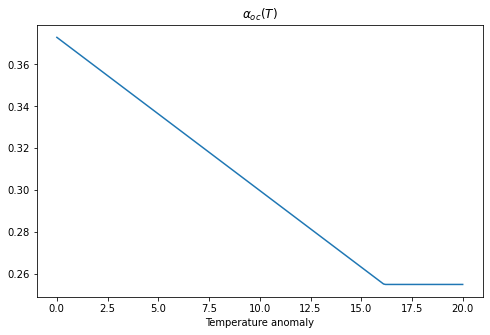

(0.255, 0.372950625)

In [28]:
α_ocean = alphaocean(T_grid + To)
plt.plot(T_grid, α_ocean)
plt.xlabel("Temperature anomaly")
plt.title("$α_{oc}(T)$")
plt.show()
α_ocean.min(), α_ocean.max()


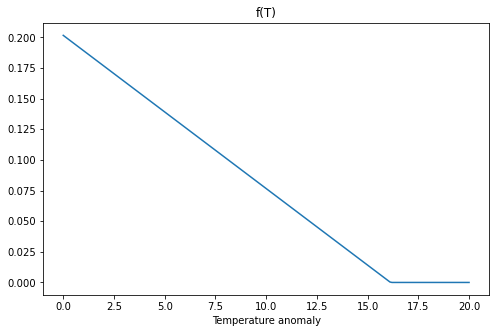

(0.0, 0.20162499999999994, 0.08140298507462679)

In [29]:
frac_sea_ice = fracseaice(T_grid + To)
plt.plot(T_grid, frac_sea_ice)
plt.xlabel("Temperature anomaly")
plt.title("f(T)")
plt.show()
frac_sea_ice.min(), frac_sea_ice.max(), frac_sea_ice.mean()

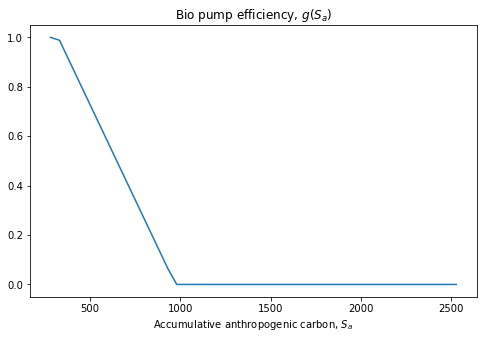

In [30]:
Fo = 272.3 # pre-industrial cumulated emission
bio_pump_efficiency = biopump(F_grid - Fo)
plt.plot(F_grid, bio_pump_efficiency)
plt.xlabel("Accumulative anthropogenic carbon, $S_a$")
plt.title("Bio pump efficiency, $g(S_a)$")
plt.show()

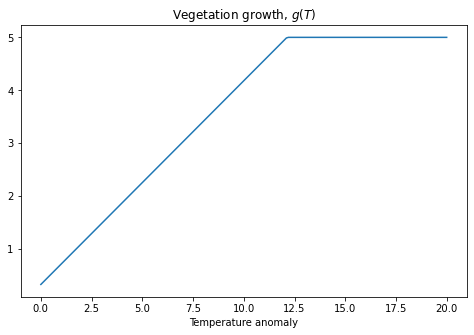

(0.33461538461538637, 5.0, 3.5806352851128977)

In [31]:
vege_growth = veggrowth(To + T_grid)


plt.plot(T_grid, vege_growth)
plt.xlabel("Temperature anomaly")
plt.title("Vegetation growth, $g(T)$")
plt.show()

vege_growth.min(), vege_growth.max(), vege_growth.mean()


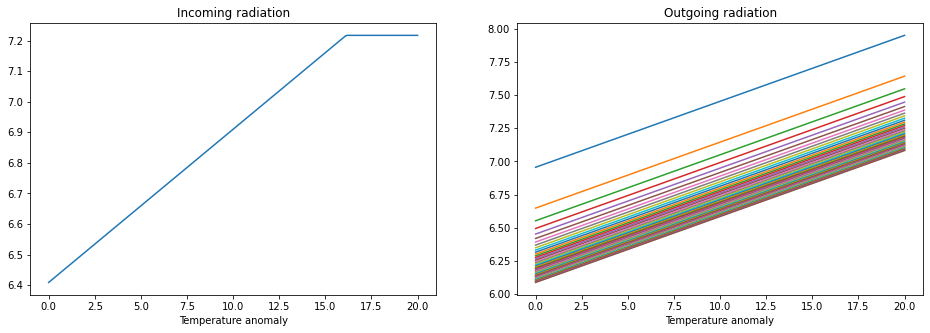

In [32]:
plt.subplots(1,2, figsize=(16, 5))
plt.subplot(121)

plt.title("Incoming radiation")
ri = Ri(To + T_grid)
ro = Ro(To + T_mat[:, 0, :], F_mat[:,0, :] - Fo)
plt.plot(T_grid, ri)
plt.xlabel("Temperature anomaly")

plt.subplot(122)
plt.title("Outgoing radiation")
plt.plot(T_grid, ro)
plt.xlabel("Temperature anomaly")
plt.show()

Text(0.5, 0, 'Temperature anomaly')

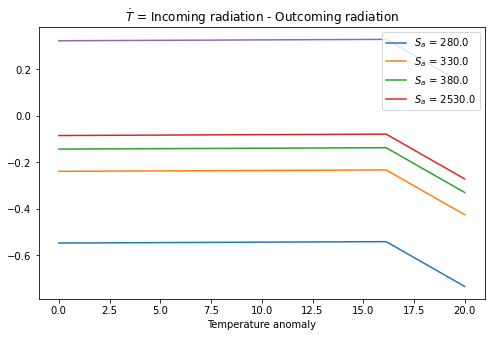

In [33]:
plt.title("$\\dot{T}$ = Incoming radiation - Outcoming radiation")
ri = Ri(To + T_mat[:, 0, :])
ro = Ro(To + T_mat[:, 0, :], F_mat[:,0, :] - Fo)
plt.plot(T_grid, (ri - ro)[:, [0, 1,2,3, -1]])
plt.legend(["$S_a$ = {}".format(F) for F in F_grid[[0, 1, 2,-1]]])
plt.xlabel("Temperature anomaly")

In [34]:
T_grid[5], F_grid[17], C_grid[1]

(0.5, 1130.0, 260)

In [35]:
(ri - ro)[6, 17], 10 * 1.86/1000

(0.17366649657357502, 0.018600000000000002)

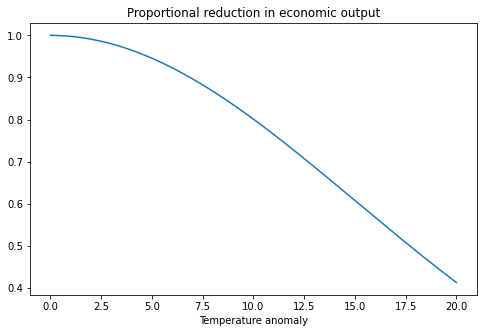

In [36]:
dG  = gamma_1 + gamma_2 * T_grid
G = gamma_1 * T_grid + gamma_2 / 2 * T_grid**2
plt.plot(T_grid, np.exp( -G) )
plt.xlabel("Temperature anomaly")
plt.title("Proportional reduction in economic output")
plt.show()

In [37]:
cearth = 35.
tauc   = 6603.

# v0 = pickle.load(open("data_35.0_6603", "rb"))["v0"]
v0 =  - eta * T_mat - eta * F_mat
# v0 =  delta * eta * np.log(delta /4 * (9000/2.13 - F_mat)) + (eta - 1) * gamma_2 * T_mat / cearth * (B * np.log(C_mat/ C0) + kappa * (T_mat + To - Tkappa))

dG  = gamma_1 + gamma_2 * T_mat
epsilon  = 0.1
count    = 0
error    = 1.
tol      = 1e-8
max_iter = 5000
fraction = 0.1


while error > tol and count < max_iter:
    
    dvdT  = finiteDiff(v0, 0, 1, hT)
    dvdTT = finiteDiff(v0, 0, 2, hT)
    dvdC  = finiteDiff(v0, 1, 1, hC)
#     dvdC[dvdC >= - 1e-16] = - 1e-16
    dvdCC = finiteDiff(v0, 1, 2, hC)
    dvdF  = finiteDiff(v0, 2, 1, hF)
    dvdFF = finiteDiff(v0, 2, 2, hF)
        
    # (dvdC + dvdF) = (dvdC + dvdF)[(dvdC + dvdF)>=-1e-32]=-1e32
    
    Ca = - eta * delta / (dvdC + dvdF)

    Ca[Ca <= 1e-32] = 1e-32
    
    if count >=1:
        Ca = Ca * fraction + Ca_star * (1 - fraction)
    
#     Ca = np.ones(T_mat.shape)
    A  = - delta * np.ones(T_mat.shape)
    B1 = Ri(T_mat + To) - Ro(T_mat + To, C_mat)
    B2 = Volcan
    B2 += Ca * sa
    B2 -= wa * C_mat * vegcover * veggrowth(T_mat +To)
    B2 += oceanatmphysflux(T_mat + To)  * (1 - fracseaice(T_mat + To))
    B2 += oceanbioflux(T_mat + To, F_mat, sa) * (1 - fracseaice(T_mat + To))
    B2 += oceanatmcorrflux(C_mat) * (1 - fracseaice(T_mat + To))
    B3 = Ca
    C1 = 0.0 * np.ones(T_mat.shape)
    C2 = 0.0 * np.ones(T_mat.shape)
    C3 = np.zeros(T_mat.shape)
    D  = eta * delta * np.log(Ca) + (eta - 1) * dG * B1

    out = PDESolver(stateSpace, A, B1, B2, B3, C1, C2, C3, D, v0, epsilon)
    v = out[2].reshape(v0.shape, order="F")

    rhs_error = A * v0 + B1 * dvdT + B2 * dvdC + B3 * dvdF + C1 * dvdTT + C2 * dvdCC + C3 * dvdFF + D
    rhs_error = np.max(abs(rhs_error))
    lhs_error = np.max(abs((v - v0)/epsilon))

    error = lhs_error
    v0 = v
    Ca_star = Ca
    count += 1

    print("Iteration: %s;\t False Transient Error: %s;\t PDE Error: %s\t" % (count, lhs_error, rhs_error))

print("Total iteration: %s;\t LHS Error: %s;\t RHS Error %s\t" % (count, lhs_error, rhs_error))

Iteration: 1;	 False Transient Error: 0.8369083578109837;	 PDE Error: 0.8378328044028169	
Iteration: 2;	 False Transient Error: 0.8359854552884372;	 PDE Error: 0.8369085936075146	
Iteration: 3;	 False Transient Error: 0.8350638610275496;	 PDE Error: 0.835985690919646	
Iteration: 4;	 False Transient Error: 0.834143574845001;	 PDE Error: 0.8350640965176157	
Iteration: 5;	 False Transient Error: 0.8332245961175033;	 PDE Error: 0.8341438102093504	
Iteration: 6;	 False Transient Error: 0.8323069237829372;	 PDE Error: 0.8332248313661407	
Iteration: 7;	 False Transient Error: 0.83139055637659;	 PDE Error: 0.8323071589217647	
Iteration: 8;	 False Transient Error: 0.8304754920850144;	 PDE Error: 0.8313907914081802	
Iteration: 9;	 False Transient Error: 0.8295617288050039;	 PDE Error: 0.8304757270094318	
Iteration: 10;	 False Transient Error: 0.8286492642049836;	 PDE Error: 0.829561963621423	
Iteration: 11;	 False Transient Error: 0.8277380957713376;	 PDE Error: 0.8286494989092777	
Iteration: 12

KeyboardInterrupt: 

In [38]:
cearth, tauc

(35.0, 6603.0)

In [61]:
B1.max(), B1.min(), v0.min(), v0.mean(), v0.max(), Ca.min(
), Ca.max(), v0.mean(), v0.std(), v0.max(), v0.min()
Ca.min(
), Ca.max()


(9.037728128985429e-17, 1374402.5663943312)

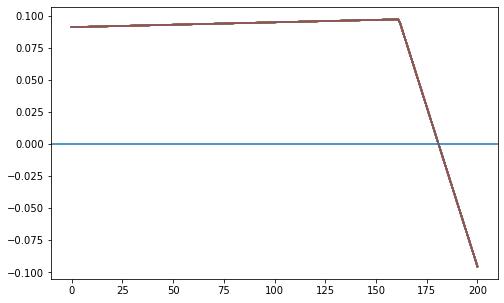

In [40]:
plt.plot(B1[:, -1, :])
plt.axhline(0)
plt.show()

In [89]:
res=pickle.load(open(f"./data/data_{cearth}_{tauc}_localdiag", "rb"))

v0 = res["v0"]
T_grid=res["T"]
C_grid = res["C"]
F_grid = res["F"]
Ca = res["Ca"]

hT = T_grid[1]-T_grid[0]
hC = C_grid[1]-C_grid[0]
hF = F_grid[1]-F_grid[0]

dvdC  = finiteDiff(v0, 1, 1, hC)
dvdF = finiteDiff(v0, 2, 1, hF)


In [107]:
from os.path import isfile, join
from os import listdir

mypath = "./data/"
onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]
onlyfiles


['data_35.0_6603.0_10_0.05_0.05_[0.0, 200.0, 0.0]_[10.0, 400.0, 2000.0]_[0.1, 2.0, 20.0]',
 'data_35.0_6603.0_10_0.05_0.05_[0.0, 200.0, 0.0]_[10.0, 400.0, 2000.0]_[0.2, 4.0, 40.0]',
 'data_35.0_6603.0_10_0.05_0.1_[0.0, 200.0, 0.0]_[10.0, 400.0, 2000.0]_[0.1, 2.0, 20.0]',
 'data_35.0_6603.0_10_0.05_0.1_[0.0, 200.0, 0.0]_[10.0, 400.0, 2000.0]_[0.2, 4.0, 40.0]',
 'data_35.0_6603.0_10_0.1_0.05_[0.0, 200.0, 0.0]_[10.0, 400.0, 2000.0]_[0.1, 2.0, 20.0]',
 'data_35.0_6603.0_10_0.1_0.05_[0.0, 200.0, 0.0]_[10.0, 400.0, 2000.0]_[0.2, 4.0, 40.0]',
 'data_35.0_6603.0_10_0.1_0.1_[0.0, 200.0, 0.0]_[10.0, 400.0, 2000.0]_[0.1, 2.0, 20.0]',
 'data_35.0_6603.0_10_0.1_0.1_[0.0, 200.0, 0.0]_[10.0, 400.0, 2000.0]_[0.2, 4.0, 40.0]',
 'data_35.0_6603.0_30000_0.05_0.05_[0.0, 200.0, 0.0]_[10.0, 400.0, 2000.0]_[0.2, 4.0, 40.0]',
 'data_35.0_6603.0_30000_0.05_0.1_[0.0, 200.0, 0.0]_[10.0, 400.0, 2000.0]_[0.2, 4.0, 40.0]',
 'data_35.0_6603.0_30000_0.1_0.05_[0.0, 200.0, 0.0]_[10.0, 400.0, 2000.0]_[0.2, 4.0, 40.0]',


In [141]:
@interact
def dataname(cearth=[35.0], tauc=[6603.0], fraction=np.array((0.05, 0.1)), epsilon=np.array((0.05, 0.1)), maxiter=np.array((10, 5000, 30000, 50000)), Tmin=[0.0], Tmax=np.array((10.0, 15.0, 17.5, 20.0)), hT=np.array((0.1, 0.2)), Cmin=[200.0], Cmax=[400.0], hC=[2.0], Fmin=[0.0], Fmax=[2000.0], hF=[20.0]):
    Xminarr = [Tmin, Cmin, Fmin]
    Xmaxarr = [Tmax, Cmax, Fmax]
    hXarr = [hT, hC, hF]
    dataname=f"./data/data_{cearth}_{tauc}_{maxiter}_{fraction}_{epsilon}_{Xminarr}_{Xmaxarr}_{hXarr}"
    print(dataname)
    res = pickle.load(open(dataname, "rb"))


interactive(children=(Dropdown(description='cearth', options=(35.0,), value=35.0), Dropdown(description='tauc'…

In [146]:
@interact
def dataname(cearth=[35.0], tauc=[6603.0], fraction=np.array((0.05, 0.1)), epsilon=np.array((0.05, 0.1)), maxiter=np.array((10, 5000, 30000, 50000)), Xminarr=[[0.0, 200.0, 0.0], [0.0, 250, 280]], Xmaxarr=[[10.0, 400.0, 2000.0], [20, 500, 2500], [15, 400, 400]], hXarr=[[0.1, 2.0, 20.0], [0.2, 4.0, 40], [0.2, 4.0, 50], [0.1, 4.0, 40]]):

    dataname = f"./data/data_{cearth}_{tauc}_{maxiter}_{fraction}_{epsilon}_{Xminarr}_{Xmaxarr}_{hXarr}"
    print(dataname)
    res = pickle.load(open(dataname, "rb"))


interactive(children=(Dropdown(description='cearth', options=(35.0,), value=35.0), Dropdown(description='tauc'…

In [160]:
from os.path import isfile, join
from os import listdir

mypath="./data/"
onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]

@interact
def present(Fnum=(0, len(F_grid)-1), Cnum=(0, len(C_grid)-1), cearth=[35.0], tauc=[6603.0], fraction=np.array((0.05, 0.1)), epsilon=np.array((0.05, 0.1)), maxiter=np.array((10, 5000, 30000, 50000)), Xminarr=[[0.0, 200.0, 0.0], [0.0, 250, 280]], Xmaxarr=[[10.0, 400.0, 2000.0], [15.0, 400.0, 400.0], [17.5, 400.0, 400.0], [20.0, 400.0, 400.0], [20.0, 500.0, 2500.0]], hXarr=[[0.1, 2.0, 20.0], [0.2, 4.0, 40.0], [0.2, 4.0, 50.0], [0.1, 4.0, 40.0]]):
    dataname = f"./data/data_{cearth}_{tauc}_{maxiter}_{fraction}_{epsilon}_{Xminarr}_{Xmaxarr}_{hXarr}"
    print(dataname)
    res = pickle.load(open(dataname, "rb"))

    v0 = res["v0"]
    T_grid = res["T"]
    C_grid = res["C"]
    F_grid = res["F"]
    Ca = res["Ca"]

    hT = T_grid[1]-T_grid[0]
    hC = C_grid[1]-C_grid[0]
    hF = F_grid[1]-F_grid[0]

    dvdC = finiteDiff(v0, 1, 1, hC)
    dvdF = finiteDiff(v0, 2, 1, hF)

    plt.subplots(1, 3, figsize=(30, 10))
    plt.subplot(131)
    plt.plot(T_grid, v0[:, Cnum, Fnum])
    plt.xlabel("Temperature (K)")
    plt.title(
        "VF, (carbon concerntration, accumulative emission)=({:.2f},{:.2f})".format(C_grid[Cnum], F_grid[Fnum]))
    plt.subplot(132)
    plt.plot(T_grid, Ca[:, Cnum, Fnum])
    plt.xlabel("Temperature (K)")
    plt.title(
        "optimal emission")
    plt.subplot(133)
    plt.plot(T_grid, dvdC[:, Cnum, Fnum]+dvdF[:, Cnum, Fnum])
    plt.xlabel("Temperature (K)")
    plt.title(
        "dvdC+dvdF")
    plt.savefig("test.pdf")


interactive(children=(IntSlider(value=22, description='Fnum', max=45), IntSlider(value=12, description='Cnum',…

<Figure size 576x360 with 0 Axes>

In [111]:
from os.path import isfile, join
from os import listdir

mypath = "./data/"
onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]


@interact
def present(Fnum=(0, len(F_grid)-1), Tnum=(0, len(T_grid)-1), data = onlyfiles):
    res = pickle.load(open("./data/"+data, "rb"))

    v0 = res["v0"]
    T_grid = res["T"]
    C_grid = res["C"]
    F_grid = res["F"]
    Ca = res["Ca"]

    hT = T_grid[1]-T_grid[0]
    hC = C_grid[1]-C_grid[0]
    hF = F_grid[1]-F_grid[0]

    dvdC = finiteDiff(v0, 1, 1, hC)
    dvdF = finiteDiff(v0, 2, 1, hF)


    plt.subplots(1, 3, figsize=(30, 8))
    plt.subplot(131)
    plt.plot(C_grid, v0[Tnum, :, Fnum])
    plt.xlabel("Temperature (K)")
    plt.title(
        "VF, (carbon concerntration, accumulative emission)=({:.2f},{:.2f})".format(T_grid[Tnum], F_grid[Fnum]))
    plt.subplot(132)
    plt.plot(C_grid, Ca[Tnum, :, Fnum])
    plt.xlabel("Temperature (K)")
    plt.title(
        "optimal emission")
    plt.subplot(133)
    plt.plot(C_grid, dvdC[Tnum, :, Fnum]+dvdF[Tnum, :, Fnum])
    plt.xlabel("Temperature (K)")
    plt.title(
        "dvdC+dvdF")


interactive(children=(IntSlider(value=22, description='Fnum', max=45), IntSlider(value=100, description='Tnum'…

In [99]:
@interact
def presentCaXT(Fnum=(0, len(F_grid)-1), Cnum=(0, len(C_grid)-1)):

    plt.plot(T_grid, v0[:, Cnum, Fnum])
    plt.xlabel("Temperature (K)")
    plt.title(
        "VF, (carbon concerntration, accumulative emission)=({:.2f},{:.2f})".format(C_grid[Cnum], F_grid[Fnum]))
    plt.show()


interactive(children=(IntSlider(value=22, description='Fnum', max=45), IntSlider(value=12, description='Cnum',…

In [79]:
@interact
def presentCaXC(Fnum=(0, len(F_grid)-1), Tnum=(0, len(T_grid)-1)):

    plt.plot(C_grid, v0[Tnum, :, Fnum])
    plt.xlabel("Carbon Concentration (ppm)")
    plt.title(
        "VF, (temperature anomaly,accumulative emission)=({:.2f},{})".format(T_grid[Tnum], F_grid[Fnum]))
    plt.show()


interactive(children=(IntSlider(value=22, description='Fnum', max=45), IntSlider(value=100, description='Tnum'…

In [92]:
@interact
def presentCaXT(Fnum=(0,len(F_grid)-1), Cnum=(0,len(C_grid)-1)):

    plt.plot(T_grid, Ca[:, Cnum, Fnum])
    plt.xlabel("Temperature (K)")
    plt.title(
        "optimal emission, (carbon concerntration, accumulative emission)=({:.2f},{:.2f})".format(C_grid[Cnum],F_grid[Fnum]))
    plt.show()


interactive(children=(IntSlider(value=22, description='Fnum', max=45), IntSlider(value=12, description='Cnum',…

In [91]:
@interact
def presentDVFXT(Fnum=(0, len(F_grid)-1), Cnum=(0, len(C_grid)-1)):

    plt.plot(T_grid, dvdC[:, Cnum, Fnum]+dvdF[:, Cnum, Fnum])
    plt.xlabel("Temperature (K)")
    plt.title(
        "dvdC+dvdF, (carbon concerntration, accumulative emission)=({:.2f},{:.2f})".format(C_grid[Cnum], F_grid[Fnum]))
    plt.show()


interactive(children=(IntSlider(value=22, description='Fnum', max=45), IntSlider(value=12, description='Cnum',…

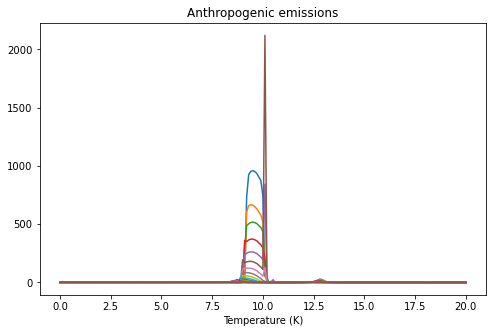

In [42]:
plt.plot(T_grid, Ca[:, :, 6])
plt.xlabel("Temperature (K)")
plt.title("Anthropogenic emissions")
plt.show()

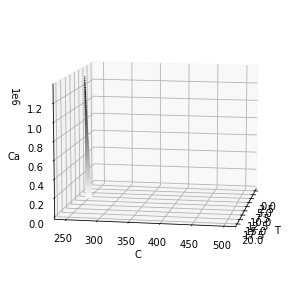

In [43]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.contour3D(T_mat[:, :, 10], C_mat[:, :, 10], Ca[:, :, ii], 90, cmap='binary')
ax.set_xlabel('T')
ax.set_ylabel('C')
ax.set_zlabel('Ca')
ax.view_init(10, 10)

In [44]:
(870 - 580) / 2.13

136.15023474178403

In [56]:
t_max = 600.
dt = 1/12
dt = 1  # , Gigaton per year
gridpoints = (T_grid, C_grid, F_grid)   
Ca_func = RegularGridInterpolator(gridpoints, Ca)

T_0 = To + min(T_grid)
C_0 = 275.5
F_0 = min(F_grid) #(870 - 580) / 2.13 # total cumulated, as of now, preindustrial with Fo

# T_0 = To + 1.1
# C_0 = 417
# F_0 = (870 - 580) / 2.13

def get_e(x):
    return Ca_func([x[0] - To, x[1], x[2]])

# Ocean albedo
def alphaocean_1d(T):
    if T < Talphaocean_low:
        return alphaocean_max
    elif T < Talphaocean_high:
        return alphaocean_max + (alphaocean_min - alphaocean_max) / (Talphaocean_high - Talphaocean_low) * (T - Talphaocean_low)
    else: # so T is higher
        return alphaocean_min

# Vegetation growth function
def veggrowth_1d(T):
    if T < Tlow:
        return 0
    if (T >= Tlow) and (T < Topt1):
        return acc / (Topt1 - Tlow) * (T - Tlow)
    if (T >= Topt1) and (T <= Topt2):
        return acc
    if (T > Topt2) and (T < Thigh):
        #return acc
        return acc / (Topt2 - Thigh) * (T - Thigh)
    if T > Thigh:
        #return acc
        return 0

def oceanatmphysflux_1d(T):
    return 1 / tauc * (coc0 * (np.exp(-bP * (T - T0))))

def fracseaice_1d(T):
    if T < Talphaocean_low:
        return 1
    elif T < Talphaocean_high:
        return 1 - 1 / (Talphaocean_high - Talphaocean_low) * (T - Talphaocean_low)
    else: # so T is higher
        return 0

def biopump_1d(Cc):
    if Cc < Cbio_low:
        return 1
    elif Cc < Cbio_high:
        return 1 - 1 / (Cbio_high - Cbio_low) * (Cc - Cbio_low)
    else: 
        return 0


def oceanbioflux_1d(T, F, sa):
     return 1/tauc * (coc0 * (np.exp(bB * biopump_1d(F) * (T - T0))))

def oceanatmcorrflux_1d(C):
    return 1 / tauc * (- cod * C)


def mu_T(x):
    Ri_t = 1 / cearth * (Q0 * (1 - p * alphaland - (1 - p) * alphaocean(x[0])))
    Ro_t = 1 / cearth * (kappa * (x[0] - Tkappa) -  B * np.log(x[1] / C0))
    return Ri_t - Ro_t

def mu_C(x):
    Ca_t = Ca_func([x[0] - To, x[1], x[2]])
    dC = Volcan
    dC += Ca_t * sa
    dC -= wa * x[1] * vegcover * veggrowth_1d(x[0])
    dC += oceanatmphysflux_1d(x[0]) * (1 - fracseaice_1d(x[0]))
    dC += oceanbioflux_1d(x[0], x[2], sa) * (1 - fracseaice_1d(x[0]))
    dC += oceanatmcorrflux_1d(x[1]) * (1 - fracseaice_1d(x[0]))
    return dC

def mu_Sa(x):
    return Ca_func([x[0] - To, x[1], x[2]])

years  = np.arange(0, t_max + dt, dt)
pers   = len(years)

hist      = np.zeros([pers, 3])
e_hist    = np.zeros([pers])


for tm in range(pers):
    if tm == 0:
        # initial points
        hist[0,:] = [T_0, C_0, F_0] # logL
        e_hist[0] = get_e(hist[0, :])

    else:
        # other periods
        e_hist[tm] = get_e(hist[tm-1,:])

        hist[tm,0] = max(hist[tm-1,0] + mu_T(hist[tm-1,:]) * dt, To + min(T_grid))
        hist[tm,1] = hist[tm-1,1] + mu_C(hist[tm-1,:]) * dt
        hist[tm,2] = hist[tm-1,2] + mu_Sa(hist[tm-1,:]) * dt


In [57]:
min(T_grid), hist

(0.0,
 array([[282.87      , 275.5       , 280.        ],
        [282.87      , 276.06610985, 281.08279625],
        [282.87015969, 276.62858584, 282.16326388],
        ...,
        [283.5576679 , 269.13007334, 883.1673421 ],
        [283.55419686, 269.22808412, 884.17375938],
        [283.55078016, 269.32774254, 885.1800428 ]]))

In [54]:
hist[10,:]


array([284.58789288, 404.40030215, 288.97165211])

Text(0.5, 1.0, '$S_a$')

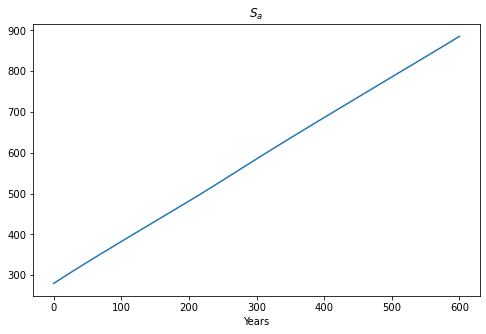

In [58]:
plt.plot(years[:], hist[:, 2])
plt.xlabel("Years")
plt.title("$S_a$")

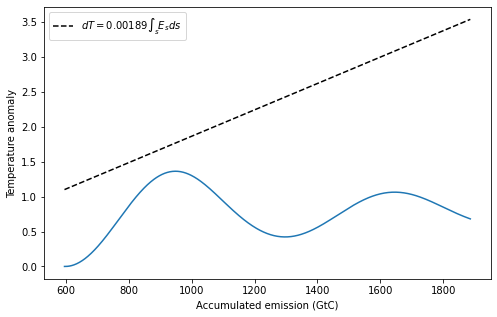

In [59]:
plt.plot(hist[:, 2] * 2.13, hist[:, 0] - To)
plt.plot(hist[:, 2] * 2.13, 1.1 +  (hist[:, 2] - hist[0, 2]) * 2.13 * 0.00189, 
         linestyle="dashed", color="black", label="$dT = 0.00189 \int_s E_s ds$")
plt.xlabel("Accumulated emission (GtC)")
plt.ylabel("Temperature anomaly")
plt.legend()
# plt.savefig("T_F_35.pdf")

In [ ]:
e_hist

array([0.90835436, 0.90835436, 0.9063891 , 0.90450251, 0.90272339,
       0.90094833, 0.89917659, 0.89740745, 0.89564027, 0.89387448,
       0.89229091, 0.89072181, 0.8891609 , 0.8876081 , 0.88608654,
       0.88463859, 0.88320844, 0.88192822, 0.88065754, 0.87939647,
       0.87814508, 0.87690352, 0.87567195, 0.87445058, 0.87333332,
       0.87233656, 0.87141923, 0.87051508, 0.86962445, 0.8687481 ,
       0.86788574, 0.8670377 , 0.86622614, 0.86547264, 0.86479524,
       0.86427459, 0.86376939, 0.86327999, 0.86280677, 0.86235014,
       0.86191053, 0.86148838, 0.8610821 , 0.86084919, 0.86072734,
       0.86061922, 0.86052556, 0.8604471 , 0.86038461, 0.86033888,
       0.86031072, 0.86034021, 0.86066746, 0.8609978 , 0.86133321,
       0.86167568, 0.86202722, 0.86238984, 0.8627562 , 0.86314235,
       0.86370687, 0.86448712, 0.86528087, 0.86609082, 0.86691962,
       0.86776988, 0.8686442 , 0.86954511, 0.87047511, 0.87168079,
       0.87365051, 0.87564216, 0.87766034, 0.87970951, 0.88179

(-0.1, 2.3166977009227248)

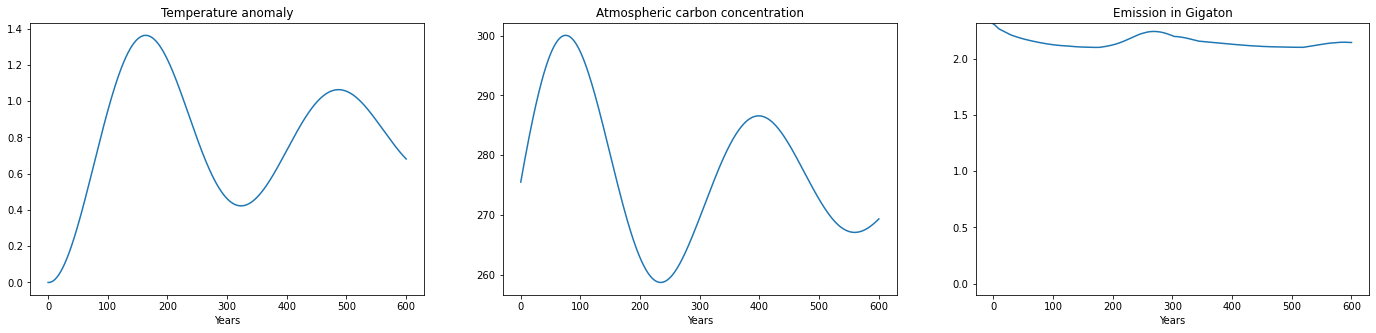

In [60]:
plt.subplots(1,3, figsize=(24,5))
plt.subplot(131)
plt.plot(years, hist[:, 0] - To)
plt.xlabel("Years")
plt.title("Temperature anomaly")
plt.subplot(132)
plt.plot(years, hist[:, 1])
plt.xlabel("Years")
plt.title("Atmospheric carbon concentration")
plt.subplot(133)
plt.plot(years, e_hist * 2.13)
plt.xlabel("Years")
plt.title("Emission in Gigaton")
plt.ylim(-0.1)
# plt.savefig(f"T_C_E_{cearth}_{tauc}.pdf")

In [80]:
res = {
    "v0": v0,
    "T": T_grid,
    "C": C_grid,
    "F": F_grid,
    "Ca": Ca,
}

pickle.dump(res, open(f"./data/data_{cearth}_{tauc}", "wb"))

In [ ]:
Et = e_hist * 2.13

Text(0.5, 1.0, 'Emission in GtC')

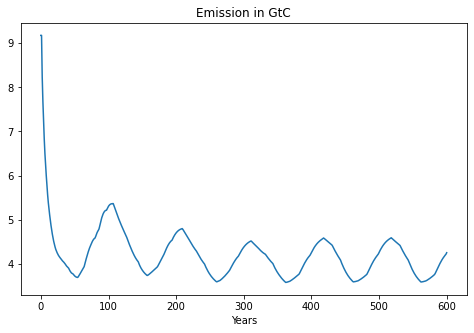

In [ ]:
plt.plot(years, Et)
plt.xlabel("Years")
plt.title("Emission in GtC")

In [ ]:
# df = pd.DataFrame({
#     'Years': years,
#     'Et(Gigaton)': Et,
#                   })

# df.to_csv("Et.csv", index=False)